In [1]:
import tonic, torch, os, pickle, glob
from tqdm import tqdm
#from utils import apply_jitter, get_loader, get_sliced_loader, make_histogram_classification, HOTS_Dataset, fit_mlr, predict_mlr, score_classif_events, plotjitter, printfig, online_accuracy, make_and_display_ts
import matplotlib.pyplot as plt
import numpy as np
from hots.layer import hotslayer
from tqdm import tqdm
from hots.timesurface import timesurface
from hots.utils import apply_jitter, get_loader, get_sliced_loader, make_histogram_classification, HOTS_Dataset, fit_mlr, predict_mlr, score_classif_events, plotjitter, printfig, online_accuracy, make_and_display_ts
import numpy as np
import matplotlib.pyplot as plt
import torch, os
import pickle

def entropy(timesurface):
    hist = torch.histc(timesurface, bins = 256, min = 0, max = 1)
    return -torch.nansum(hist*torch.log2(hist))

class network_pooling(object):

    def __init__(self,  name,
                        dataset_name,
                        timestr, # date of creation of the network 
                        sensor_size, # 
                        nb_neurons = (4,8,16), # architecture of the network (default=Lagorce2017)
                        # parameters of time-surfaces and datasets
                        tau = (1e1,1e2,1e3), #time constant for exponential decay in millisec
                        R = (2,4,8), # parameter defining the spatial size of the time surface
                        homeo = True, # parameters for homeostasis (None is no homeo rule)
                        to_record = False,
                        record_path = '../Records/',
                        device = 'cuda',
                ):
        assert len(nb_neurons) == len(R) & len(nb_neurons) == len(tau)
        
        self.name = f'{timestr}_{dataset_name}_{name}_{homeo}_{nb_neurons}_{tau}_{R}'
        nb_layers = len(nb_neurons)
        self.n_pola = [nb_neurons[L] for L in range(nb_layers-1)]
        self.n_pola.insert(0,2)
        # pooling
        self.channel_size = [(sensor_size[0]//(2*L), sensor_size[1]//(2*L)) for L in range(1,nb_layers)]
        self.channel_size.insert(0,(sensor_size[0], sensor_size[1]))
        self.tau = tau
        self.R = R
        self.record_path = record_path
        
        # pooling
        for L in range(nb_layers):
            assert (2*(L+1))**2 <= self.channel_size[L][0]*self.channel_size[L][1]
        
        path = self.record_path+'networks/'+self.name+'.pkl'
        if os.path.exists(path):
            with open(path, 'rb') as file:
                my_network = pickle.load(file)
            self.layers = my_network.layers
            for L in range(len(self.layers)):
                self.layers[L] = self.layers[L].to(device)
            
        else:
            self.layers = [hotslayer((2*R[L]+1)**2*self.n_pola[L], nb_neurons[L], homeostasis=homeo, device=device) for L in range(nb_layers)]
            
    def clustering(self, loader, ordering, filtering_threshold = None, ts_batch_size = None, device = 'cuda', record = False):
        path = self.record_path+'networks/'+self.name+'.pkl'
        if not os.path.exists(path):
            p_index = ordering.index('p')
            x_index = ordering.index('x')
            y_index = ordering.index('y')
            
            for L in range(len(self.tau)):
                self.layers[L] = self.layers[L].to(device)
                self.layers[L].cumhisto = self.layers[L].cumhisto.to(device)
            
            if record:
                ent = []
                loss = []
                delta_w = []
                homeostasis = []

            with torch.no_grad():
                
                if not filtering_threshold: filtering_threshold = [None for L in range(len(self.tau))]
                
                for events, target in tqdm(loader):
                    events = events.squeeze(0)
                    if record:
                        previous_dic = [self.layers[L].synapses.weight.data.T.detach().clone() for L in range(len(self.tau))]
                    for L in range(len(self.tau)):
                        ts_batch_size_per_layer = int(ts_batch_size*(self.n_pola[0]*(2*self.R[0]+1)**2)/(self.n_pola[L]*(2*self.R[L]+1)**2))
                        nb_batch = len(events)//ts_batch_size_per_layer
                        print(nb_batch, ts_batch_size_per_layer, len(events))
                        if nb_batch:
                            previous_timestamp = []
                            outputs = torch.Tensor([])
                            ind_outputs = torch.Tensor([])
                            for load_nb in range(nb_batch+1):
                                all_ts, ind_filtered_timesurface, previous_timestamp = timesurface(events, (self.channel_size[L][0], self.channel_size[L][1], self.n_pola[L]), ordering, tau = self.tau[L], surface_dimensions=[2*self.R[L]+1,2*self.R[L]+1], filtering_threshold = filtering_threshold[L], ts_batch_size = ts_batch_size_per_layer, load_number = load_nb, previous_timestamp = previous_timestamp, device = device)
                                n_star, _, beta = self.layers[L](all_ts, True)
                                outputs = torch.hstack([outputs,n_star]) if outputs.shape[0]>0 else n_star
                                ind_outputs = torch.hstack([ind_outputs,ind_filtered_timesurface+load_nb*ts_batch_size_per_layer]) if ind_outputs.shape[0]>0 else ind_filtered_timesurface
                                if record:
                                    proto_ts = all_ts.detach().clone()
                                    kernels = self.layers[L].synapses.weight.data.T
                                    DIFF = 0
                                    for ev in range(len(n_star)):
                                        proto_ts[ev,:,:,:] = torch.reshape(kernels[:,int(n_star[ev].cpu())], (self.n_pola[L], 2*self.R[L]+1, 2*self.R[L]+1))
                                        diff = torch.linalg.norm(all_ts[ev,:,:,:]-proto_ts[ev,:,:,:])
                                        DIFF += diff.mean()
                                    DIFF/=len(n_star)
                                    loss.append(DIFF.cpu())
                                    ent.append(entropy(kernels))
                                    delta_w.append((kernels-previous_dic[L]).abs().mean().cpu())
                                    homeostasis.append((self.layers[L].cumhisto/self.layers[L].cumhisto.sum()-1/kernels.shape[1]).abs().mean().cpu())
                                del all_ts
                                torch.cuda.empty_cache()
                            events = events[ind_outputs,:]
                            events[:,p_index] = outputs.cpu()
                        else:
                            all_ts, ind_filtered_timesurface = timesurface(events, (self.channel_size[L][0], self.channel_size[L][1], self.n_pola[L]), ordering, tau = self.tau[L], surface_dimensions=[2*self.R[L]+1,2*self.R[L]+1], filtering_threshold = filtering_threshold[L], device=device)
                            n_star, _, beta  = self.layers[L](all_ts, True)
                            if record:
                                proto_ts = all_ts.detach().clone()
                                kernels = self.layers[L].synapses.weight.data.T
                                DIFF = 0
                                for ev in range(len(n_star)):
                                    proto_ts[ev,:,:,:] = torch.reshape(kernels[:,int(n_star[ev].cpu())], (self.n_pola[L], 2*self.R[L]+1, 2*self.R[L]+1))
                                    diff = torch.linalg.norm(all_ts[ev,:,:,:]-proto_ts[ev,:,:,:])
                                    DIFF += diff.mean()
                                DIFF/=len(n_star)
                                loss.append(DIFF.cpu())
                                ent.append(entropy(kernels))
                                delta_w.append((kernels-previous_dic[L]).abs().mean().cpu())
                                homeostasis.append((self.layers[L].cumhisto/self.layers[L].cumhisto.sum()-1/kernels.shape[1]).abs().mean().cpu())
                            del all_ts
                            torch.cuda.empty_cache()
                            events = events[ind_filtered_timesurface,:]
                            events[:,p_index] = n_star.cpu()
                        events[:,x_index] = torch.div(events[:,x_index], (2*self.R[L]+1), rounding_mode='floor')
                        events[:,y_index] = torch.div(events[:,y_index], (2*self.R[L]+1), rounding_mode='floor')
                        if events.shape[0]==0: break

            with open(path, 'wb') as file:
                pickle.dump(self, file, pickle.HIGHEST_PROTOCOL)
            if record:
                path = self.record_path+'networks/'+self.name+'_recorded_parameters.pkl'
                with open(path, 'wb') as file:
                    pickle.dump([loss, ent, delta_w, homeostasis], file, pickle.HIGHEST_PROTOCOL)
            
            
    def coding(self, loader, ordering, classes, training, ts_batch_size = None, filtering_threshold = None, jitter=(None,None), layer_threshold = None, device = 'cuda', verbose=True):
        
        #homeostatic gain control is used only for the clustering phase
        for L in range(len(self.tau)):
            self.layers[L].homeo_flag = False
            self.layers[L] = self.layers[L].to(device)
            self.layers[L].cumhisto = self.layers[L].cumhisto.to(device)
        
        if not filtering_threshold: filtering_threshold = [None for L in range(len(self.tau))]
        if not layer_threshold: layer_threshold = [None for L in range(len(self.tau))]
        
        p_index = ordering.index('p')
        x_index = ordering.index('x')
        y_index = ordering.index('y')
        
        if training:
            output_path = self.record_path+f'output/train/{self.name}_{len(loader)}_{jitter}/'
        else: output_path = self.record_path+f'output/test/{self.name}_{len(loader)}_{jitter}/'
        
        if os.path.exists(output_path):
            if verbose:
                print(f'this dataset have already been processed, check at: \n {output_path}')
        else:
            for classe in classes:
                os.makedirs(output_path+f'{classe}')
            
            with torch.no_grad():
                nb = 0
                for events, target in tqdm(loader):
                    events = events.squeeze(0)
                    for L in range(len(self.tau)):
                        ts_batch_size_per_layer = int(ts_batch_size*(self.n_pola[0]*(2*self.R[0]+1)**2)/(self.n_pola[L]*(2*self.R[L]+1)**2))
                        nb_batch = len(events)//ts_batch_size_per_layer
                        if nb_batch:
                            previous_timestamp = []
                            outputs = torch.Tensor([])
                            ind_outputs = torch.Tensor([])
                            for load_nb in range(nb_batch+1):
                                all_ts, ind_filtered_timesurface, previous_timestamp = timesurface(events, (self.channel_size[L][0], self.channel_size[L][1], self.n_pola[L]), ordering, tau = self.tau[L], surface_dimensions=[2*self.R[L]+1,2*self.R[L]+1], filtering_threshold = filtering_threshold[L], ts_batch_size = ts_batch_size_per_layer, load_number = load_nb, previous_timestamp = previous_timestamp, device = device)
                                n_star, ind_filtered_layer, beta = self.layers[L](all_ts, False)
                                ind_to_keep = ind_filtered_timesurface[ind_filtered_layer]
                                outputs = torch.hstack([outputs,n_star]) if outputs.shape[0]>0 else n_star
                                ind_outputs = torch.hstack([ind_outputs,ind_to_keep+load_nb*ts_batch_size_per_layer]) if ind_outputs.shape[0]>0 else ind_to_keep
                                del all_ts
                                torch.cuda.empty_cache()
                            events = events[ind_outputs,:]
                            events[:,p_index] = outputs.cpu()
                        else:
                            all_ts, ind_filtered_timesurface = timesurface(events, (self.channel_size[L][0], self.channel_size[L][1], self.n_pola[L]), ordering, tau = self.tau[L], surface_dimensions=[2*self.R[L]+1,2*self.R[L]+1], filtering_threshold = filtering_threshold[L], device=device)
                            n_star, ind_filtered_layer, beta = self.layers[L](all_ts, False)
                            events = events[ind_filtered_timesurface,:]
                            events[:,p_index] = n_star.cpu()
                            events = events[ind_filtered_layer,:]
                            del all_ts
                            torch.cuda.empty_cache()
                            
                        events[:,x_index] = torch.div(events[:,x_index], (2*self.R[L]+1), rounding_mode='floor')
                        events[:,y_index] = torch.div(events[:,y_index], (2*self.R[L]+1), rounding_mode='floor')
                        if events.shape[0]==0: 
                            complete_flag = False
                            break
                        else:
                            complete_flag = True

                    if complete_flag:
                        np.save(output_path+f'{classes[target]}/{nb}', events)
                    nb+=1
                    
                    
    def plotlayers(self, maxpol=None, hisiz=2, yhis=0.3):
        '''
        '''
        N = []
        P = [2]
        R2 = []
        kernels = []
        for L in range(len(self.tau)):
            kernels.append(self.layers[L].synapses.weight.data.T.cpu().numpy())
            N.append(int(kernels[L].shape[1]))
            if L>0:
                P.append(int(kernels[L-1].shape[1]))
            R2.append(int(kernels[L].shape[0]/P[L]))
        if maxpol is None:
            maxpol=P[-1]

        fig = plt.figure(figsize=(16,9))
        gs = fig.add_gridspec(np.sum(P)+hisiz, np.sum(N)+len(self.tau)-1, wspace=0.05, hspace=0.05)
        if self.layers[-1].homeo_flag:
            fig.suptitle('Unsupervised clustering with homeostasis', size=20, y=0.95)
        else:
            fig.suptitle('Unsupervised clustering for original HOTS', size=20, y=0.95)

        for L in range(len(self.tau)):
            ax = fig.add_subplot(gs[:hisiz, int(np.sum(N[:L]))+1*L:int(np.sum(N[:L+1]))+L*1])
            plt.bar(np.arange(N[L]), (self.layers[L].cumhisto/torch.sum(self.layers[L].cumhisto)).cpu(), width=1, align='edge', ec="k")
            ax.set_xticks(())
            ax.set_title('Layer '+str(L+1), fontsize=16)
            plt.xlim([0,N[L]])
            yhis = 1.1*max(self.layers[L].cumhisto/torch.sum(self.layers[L].cumhisto)).cpu()
            plt.ylim([0,yhis])

            for k in range(N[L]):
                vmaxi = max(kernels[L][:,k])
                for j in range(P[L]):
                    if j>maxpol-1:
                        pass
                    else:
                        axi = fig.add_subplot(gs[j+hisiz,k+1*L+int(np.sum(N[:L]))])
                        krnl = kernels[L][j*R2[L]:(j+1)*R2[L],k].reshape((int(np.sqrt(R2[L])), int(np.sqrt(R2[L]))))

                        axi.imshow(krnl, vmin=0, vmax=vmaxi, cmap=plt.cm.plasma, interpolation='nearest')
                        axi.set_xticks(())
                        axi.set_yticks(())
        plt.show()
        return fig
    
    def plotlearning(self, width_fig = 30):
        path = self.record_path+'networks/'+self.name+'_recorded_parameters.pkl'
        with open(path, 'rb') as file:
            loss, entropy, delta_w, homeostasis = pickle.load(file)
            
        n_layers = len(self.tau)
        fig, axs = plt.subplots(n_layers,4, figsize=(width_fig,n_layers*width_fig//4))
        for L in range(n_layers):
            loss_layer = loss[L::n_layers]
            entropy_layer = entropy[L::n_layers]
            delta_w_layer = delta_w[L::n_layers]
            homeostasis_layer = homeostasis[L::n_layers]
            axs[L,0].plot(loss_layer)
            axs[L,1].plot(entropy_layer)
            axs[L,2].plot(delta_w_layer)
            axs[L,3].plot(homeostasis_layer)
            if L == 0:
                axs[L,0].set_title('average loss')
                axs[L,1].set_title('average entropy values for the time surfaces')
                axs[L,2].set_title('average gradient of the weights')
                axs[L,3].set_title('average homeostasic gain')
        plt.show()



print(f'Tonic version installed -> {tonic.__version__}')

print(f'Number of GPU devices available: {torch.cuda.device_count()}')
for N_gpu in range(torch.cuda.device_count()):
    print(f'GPU {N_gpu+1} named {torch.cuda.get_device_name(N_gpu)}')
    
#record_path = '/envau/work/neopto/USERS/GRIMALDI/HOTS/hotsline/Records/'
record_path = '../Records/'

device = 'cuda'

kfold_test = None
kfold_clust = 10
ts_batch_size = int(1e5)

dataset_name = 'gesture'
slicing_time_window = 2e6
only_first = True

#to uncomment 
trainset = tonic.datasets.DVSGesture(save_to='../../Data/', train=True)
testset = tonic.datasets.DVSGesture(save_to='../../Data/', train=False)
trainloader = get_sliced_loader(trainset, slicing_time_window, dataset_name, True, only_first=only_first)
testloader = get_sliced_loader(testset, slicing_time_window, dataset_name, False, only_first=only_first)
print('--- Slicing dataset done ---')

type_transform = tonic.transforms.NumpyAsType(int)
trainset = tonic.datasets.DVSGesture(save_to='../../Data/', train=True, transform=type_transform)
testset = tonic.datasets.DVSGesture(save_to='../../Data/', train=False, transform=type_transform)
loader = get_sliced_loader(trainset, slicing_time_window, dataset_name, True, only_first=only_first, kfold=kfold_clust)
trainloader = get_sliced_loader(trainset, slicing_time_window, dataset_name, True, only_first=only_first, kfold=kfold_test)
num_sample_train = len(trainloader)
testloader = get_sliced_loader(testset, slicing_time_window, dataset_name, False, only_first=only_first, kfold=kfold_test)
num_sample_test = len(testloader)
n_classes = len(testset.classes)

name = 'homeohots_pool'
homeo = True
timestr = '2023-04-14'
dataset_name = 'gesture'

Rz = [2, 2]
N_neuronz = [32, 64]
tauz = [5e3*2, 5e3*N_neuronz[0]]#/(2*Rz[0]+1)**2]

hots = network_pooling(name, dataset_name, timestr, trainset.sensor_size, nb_neurons = N_neuronz, tau = tauz, R = Rz, homeo = homeo, record_path=record_path)

initial_name = hots.name

filtering_threshold = [2*Rz[L] for L in range(len(Rz))]
if not os.path.exists(record_path):
    os.mkdir(record_path)
    os.mkdir(record_path+'networks/')
path = record_path+'networks/'+hots.name+'.pkl'
if not os.path.exists(path):
    hots.clustering(loader, trainset.ordering, filtering_threshold = filtering_threshold, ts_batch_size = None, record = True, device = device)
#hots.plotlayers();

jitter = (None, None)
N_output_neurons = N_neuronz[-1]
layer_threshold = None#[0.05, 0.1]

hots.coding(trainloader, trainset.ordering, trainset.classes, layer_threshold = layer_threshold, training=True, ts_batch_size = ts_batch_size, verbose=False, device = device)
hots.coding(testloader, trainset.ordering, trainset.classes, layer_threshold = layer_threshold, training=False, ts_batch_size = ts_batch_size, verbose=False, device = device)

train_path = f'../Records/output/train/{hots.name}_{num_sample_train}_{jitter}/'
test_path = f'../Records/output/test/{hots.name}_{num_sample_test}_{jitter}/'

trainset_output = HOTS_Dataset(train_path, trainset.sensor_size, trainset.classes, dtype=trainset.dtype, transform=tonic.transforms.Compose([type_transform]))
trainoutputloader = get_loader(trainset_output)
testset_output = HOTS_Dataset(test_path, testset.sensor_size, testset.classes, dtype=testset.dtype, transform=type_transform)
testoutputloader = get_loader(testset_output)

score = make_histogram_classification(trainset_output, testset_output, N_output_neurons)
print(f'Histogram classification performance: {np.round(score,3)*100} %')

num_workers = 0
learning_rate = 0.00005
beta1, beta2 = 0.9, 0.999
betas = (beta1, beta2)
num_epochs = 7#2 ** 5 + 1
sensor_size = (trainset.sensor_size[0]//25+1,trainset.sensor_size[1]//25+1, N_output_neurons)
tau_cla = 5e3*N_neuronz[-1]
drop_proba = .95

ts_size = None#(31,31)
ts_batch_size = int(1e5)

drop_transform = tonic.transforms.DropEvent(p = drop_proba)

kfold_mlr = 5

trainoutputloader = get_loader(trainset_output)
testoutputloader = get_loader(testset_output)

if kfold_mlr:
    trainoutputloader = get_loader(trainset_output, kfold = kfold_mlr)
    testoutputloader = get_loader(testset_output, kfold = kfold_mlr//2)

print(f'number of samples in the training set: {len(trainoutputloader)}')
print(f'number of samples in the testing set: {len(testoutputloader)}')

tau_cla_list = [int(1e6), int(2e6), int(3e6), int(4e6), int(5e6)]#, int(1e4), int(1e5), int(1e6), int(1e7), int(1e8)]#[int(1e3), int(5e3), int(1e4), int(5e4), int(1e5), int(2e5), int(3e5), int(5e5), int(1e6), int(2e6), int(3e6), int(4e6), int(5e6), int(6e6)]

for tau_cla in tau_cla_list:
    
    model_path = f'../Records/networks/{hots.name}_conv_{tau_cla}_{learning_rate}_{betas}_{num_epochs}_{drop_proba}_{jitter}.pkl'
    results_path = f'../Records/LR_results/{hots.name}_conv_{tau_cla}_{learning_rate}_{betas}_{num_epochs}_{drop_proba}_{jitter}.pkl'
    print(model_path)
    
    classif_layer, losses = fit_mlr(trainoutputloader, model_path, tau_cla, learning_rate, betas, num_epochs, sensor_size, trainset.ordering, len(trainset.classes), ts_size = ts_size, ts_batch_size = ts_batch_size, drop_proba = drop_proba)

    mlr_threshold = None
    onlinac, best_probability, meanac, lastac = online_accuracy(classif_layer, tau_cla, testoutputloader, results_path, sensor_size, testset_output.ordering, n_classes, ts_size = ts_size, mlr_threshold = mlr_threshold, ts_batch_size = int(ts_batch_size/2), save_likelihood = False)

Tonic version installed -> 1.0.19
Number of GPU devices available: 1
GPU 1 named GeForce RTX 2080 Ti
Read metadata from disk.
Read metadata from disk.
--- Slicing dataset done ---
Read metadata from disk.
Read metadata from disk.
Read metadata from disk.
Histogram classification performance: 86.7 %
number of samples in the training set: 209
number of samples in the testing set: 132
../Records/networks/2023-04-14_gesture_homeohots_pool_True_[32, 64]_[10000.0, 160000.0]_[2, 2]_conv_1000000_5e-05_(0.9, 0.999)_7_0.95_(None, None).pkl
Number of chance decisions: 0
90th quantile for number of events: 237810.30000000002
Mean accuracy: 77.60000000000001%
Last accuracy: 75.0%
Highest probability accuracy: 76.5%
../Records/networks/2023-04-14_gesture_homeohots_pool_True_[32, 64]_[10000.0, 160000.0]_[2, 2]_conv_2000000_5e-05_(0.9, 0.999)_7_0.95_(None, None).pkl
device -> cuda


  0%|                                                                                                                                                                                                                                                   | 0/6 [01:02<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
plt.plot(losses)

In [ ]:
mlr_threshold = .6
onlinac, best_probability, meanac, lastac = online_accuracy(classif_layer, tau_cla, testoutputloader, results_path, sensor_size, testset_output.ordering, n_classes, ts_size = ts_size, mlr_threshold = mlr_threshold, ts_batch_size = int(ts_batch_size/2), save_likelihood = False)

Tonic version installed -> 1.0.19
Number of GPU devices available: 1
GPU 1 named GeForce RTX 2080 Ti
Read metadata from disk.
Read metadata from disk.
--- Slicing dataset done ---
Read metadata from disk.
Read metadata from disk.
Read metadata from disk.
number of samples in the training set: 1077
number of samples in the testing set: 264
../Records/networks/2023-05-23_gesture_homeohots_pool_True_[32, 64]_[10000.0, 160000.0]_[2, 2].pkl
../Records/networks/2023-05-23_gesture_homeohots_pool_False_[32, 64]_[10000.0, 160000.0]_[2, 2].pkl
number of samples in the training set: 1077
number of samples in the testing set: 264
Histogram classification performance: 83.0 %
Histogram classification performance (no homeo): 70.5 %
(6, 6, 64)
../Records/networks/2023-05-23_gesture_homeohots_pool_True_[32, 64]_[10000.0, 160000.0]_[2, 2]_conv_1000000_5e-05_(0.9, 0.999)_33_0.95_(None, None).pkl
Number of chance decisions: 0
90th quantile for number of events: 344719.30000000005
Mean accuracy: 85.7%
Last

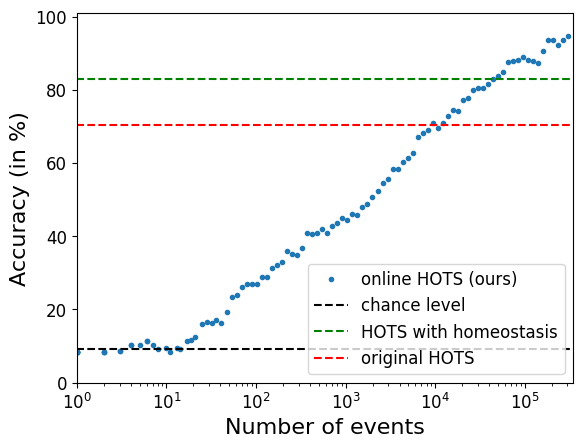

In [6]:
import tonic, torch, os, pickle, glob
from tqdm import tqdm
from hots.utils import apply_jitter, get_loader, get_sliced_loader, make_histogram_classification, HOTS_Dataset, fit_mlr, predict_mlr, score_classif_events, plotjitter, printfig, online_accuracy, make_and_display_ts
import matplotlib.pyplot as plt
import numpy as np
from hots.layer import hotslayer
from tqdm import tqdm
from hots.timesurface import timesurface
import numpy as np
import matplotlib.pyplot as plt
import torch, os
import pickle

def entropy(timesurface):
    hist = torch.histc(timesurface, bins = 256, min = 0, max = 1)
    return -torch.nansum(hist*torch.log2(hist))

class network_pooling(object):

    def __init__(self,  name,
                        dataset_name,
                        timestr, # date of creation of the network 
                        sensor_size, # 
                        nb_neurons = (4,8,16), # architecture of the network (default=Lagorce2017)
                        # parameters of time-surfaces and datasets
                        tau = (1e1,1e2,1e3), #time constant for exponential decay in millisec
                        R = (2,4,8), # parameter defining the spatial size of the time surface
                        homeo = True, # parameters for homeostasis (None is no homeo rule)
                        to_record = False,
                        record_path = '../Records/',
                        device = 'cuda',
                ):
        assert len(nb_neurons) == len(R) & len(nb_neurons) == len(tau)
        
        self.name = f'{timestr}_{dataset_name}_{name}_{homeo}_{nb_neurons}_{tau}_{R}'
        nb_layers = len(nb_neurons)
        self.n_pola = [nb_neurons[L] for L in range(nb_layers-1)]
        self.n_pola.insert(0,2)
        # pooling
        self.channel_size = [(sensor_size[0]//(2*L), sensor_size[1]//(2*L)) for L in range(1,nb_layers)]
        self.channel_size.insert(0,(sensor_size[0], sensor_size[1]))
        self.tau = tau
        self.R = R
        self.record_path = record_path
        
        # pooling
        for L in range(nb_layers):
            assert (2*(L+1))**2 <= self.channel_size[L][0]*self.channel_size[L][1]
        
        path = self.record_path+'networks/'+self.name+'.pkl'
        print(path)
        if os.path.exists(path):
            with open(path, 'rb') as file:
                my_network = pickle.load(file)
            self.layers = my_network.layers
            for L in range(len(self.layers)):
                self.layers[L] = self.layers[L].to(device)
            
        else:
            self.layers = [hotslayer((2*R[L]+1)**2*self.n_pola[L], nb_neurons[L], homeostasis=homeo, device=device) for L in range(nb_layers)]
            
    def clustering(self, loader, ordering, filtering_threshold = None, ts_batch_size = None, device = 'cuda', record = False):
        path = self.record_path+'networks/'+self.name+'.pkl'
        if not os.path.exists(path):
            p_index = ordering.index('p')
            x_index = ordering.index('x')
            y_index = ordering.index('y')
            
            for L in range(len(self.tau)):
                self.layers[L] = self.layers[L].to(device)
                self.layers[L].cumhisto = self.layers[L].cumhisto.to(device)
            
            if record:
                ent = []
                loss = []
                delta_w = []
                homeostasis = []

            with torch.no_grad():
                
                if not filtering_threshold: filtering_threshold = [None for L in range(len(self.tau))]
                
                for events, target in tqdm(loader):
                    events = events.squeeze(0)
                    if record:
                        previous_dic = [self.layers[L].synapses.weight.data.T.detach().clone() for L in range(len(self.tau))]
                    for L in range(len(self.tau)):
                        if ts_batch_size: 
                            ts_batch_size_per_layer = int(ts_batch_size*(self.n_pola[0]*(2*self.R[0]+1)**2)/(self.n_pola[L]*(2*self.R[L]+1)**2))
                            nb_batch = len(events)//ts_batch_size_per_layer
                        else: nb_batch = 0
                        if nb_batch:
                            previous_timestamp = []
                            outputs = torch.Tensor([])
                            ind_outputs = torch.Tensor([])
                            for load_nb in range(nb_batch+1):
                                all_ts, ind_filtered_timesurface, previous_timestamp = timesurface(events, (self.channel_size[L][0], self.channel_size[L][1], self.n_pola[L]), ordering, tau = self.tau[L], surface_dimensions=[2*self.R[L]+1,2*self.R[L]+1], filtering_threshold = filtering_threshold[L], ts_batch_size = ts_batch_size_per_layer, load_number = load_nb, previous_timestamp = previous_timestamp, device = device)
                                n_star, _, beta = self.layers[L](all_ts, True)
                                outputs = torch.hstack([outputs,n_star]) if outputs.shape[0]>0 else n_star
                                ind_outputs = torch.hstack([ind_outputs,ind_filtered_timesurface+load_nb*ts_batch_size_per_layer]) if ind_outputs.shape[0]>0 else ind_filtered_timesurface
                                if record:
                                    proto_ts = all_ts.detach().clone()
                                    kernels = self.layers[L].synapses.weight.data.T
                                    DIFF = 0
                                    for ev in range(len(n_star)):
                                        proto_ts[ev,:,:,:] = torch.reshape(kernels[:,int(n_star[ev].cpu())], (self.n_pola[L], 2*self.R[L]+1, 2*self.R[L]+1))
                                        diff = torch.linalg.norm(all_ts[ev,:,:,:]-proto_ts[ev,:,:,:])
                                        DIFF += diff.mean()
                                    DIFF/=len(n_star)
                                    loss.append(DIFF.cpu())
                                    ent.append(entropy(kernels))
                                    delta_w.append((kernels-previous_dic[L]).abs().mean().cpu())
                                    homeostasis.append((self.layers[L].cumhisto/self.layers[L].cumhisto.sum()-1/kernels.shape[1]).abs().mean().cpu())
                                del all_ts
                                torch.cuda.empty_cache()
                            events = events[ind_outputs,:]
                            events[:,p_index] = outputs.cpu()
                        else:
                            all_ts, ind_filtered_timesurface = timesurface(events, (self.channel_size[L][0], self.channel_size[L][1], self.n_pola[L]), ordering, tau = self.tau[L], surface_dimensions=[2*self.R[L]+1,2*self.R[L]+1], filtering_threshold = filtering_threshold[L], device=device)
                            n_star, _, beta  = self.layers[L](all_ts, True)
                            if record:
                                proto_ts = all_ts.detach().clone()
                                kernels = self.layers[L].synapses.weight.data.T
                                DIFF = 0
                                for ev in range(len(n_star)):
                                    proto_ts[ev,:,:,:] = torch.reshape(kernels[:,int(n_star[ev].cpu())], (self.n_pola[L], 2*self.R[L]+1, 2*self.R[L]+1))
                                    diff = torch.linalg.norm(all_ts[ev,:,:,:]-proto_ts[ev,:,:,:])
                                    DIFF += diff.mean()
                                DIFF/=len(n_star)
                                loss.append(DIFF.cpu())
                                ent.append(entropy(kernels))
                                delta_w.append((kernels-previous_dic[L]).abs().mean().cpu())
                                homeostasis.append((self.layers[L].cumhisto/self.layers[L].cumhisto.sum()-1/kernels.shape[1]).abs().mean().cpu())
                            del all_ts
                            torch.cuda.empty_cache()
                            events = events[ind_filtered_timesurface,:]
                            events[:,p_index] = n_star.cpu()
                        events[:,x_index] = torch.div(events[:,x_index], (2*self.R[L]+1), rounding_mode='floor')
                        events[:,y_index] = torch.div(events[:,y_index], (2*self.R[L]+1), rounding_mode='floor')
                        if events.shape[0]==0: break

            with open(path, 'wb') as file:
                pickle.dump(self, file, pickle.HIGHEST_PROTOCOL)
            if record:
                path = self.record_path+'networks/'+self.name+'_recorded_parameters.pkl'
                with open(path, 'wb') as file:
                    pickle.dump([loss, ent, delta_w, homeostasis], file, pickle.HIGHEST_PROTOCOL)
            
            
    def coding(self, loader, ordering, classes, training, ts_batch_size = None, filtering_threshold = None, jitter=(None,None), layer_threshold = None, device = 'cuda', verbose=True):
        
        #homeostatic gain control is used only for the clustering phase
        for L in range(len(self.tau)):
            self.layers[L].homeo_flag = False
            self.layers[L] = self.layers[L].to(device)
            self.layers[L].cumhisto = self.layers[L].cumhisto.to(device)
        
        if not filtering_threshold: filtering_threshold = [None for L in range(len(self.tau))]
        if not layer_threshold: layer_threshold = [None for L in range(len(self.tau))]
        
        p_index = ordering.index('p')
        x_index = ordering.index('x')
        y_index = ordering.index('y')
        
        if training:
            output_path = self.record_path+f'output/train/{self.name}_{len(loader)}_{jitter}/'
        else: output_path = self.record_path+f'output/test/{self.name}_{len(loader)}_{jitter}/'
        
        if os.path.exists(output_path):
            if verbose:
                print(f'this dataset have already been processed, check at: \n {output_path}')
        else:
            for classe in classes:
                os.makedirs(output_path+f'{classe}')
            
            with torch.no_grad():
                nb = 0
                for events, target in tqdm(loader):
                    events = events.squeeze(0)
                    for L in range(len(self.tau)):
                        if ts_batch_size:
                            ts_batch_size_per_layer = int(ts_batch_size*(self.n_pola[0]*(2*self.R[0]+1)**2)/(self.n_pola[L]*(2*self.R[L]+1)**2))
                            nb_batch = len(events)//ts_batch_size_per_layer
                        else: nb_batch = 0
                        if nb_batch:
                            previous_timestamp = []
                            outputs = torch.Tensor([])
                            ind_outputs = torch.Tensor([])
                            for load_nb in range(nb_batch+1):
                                all_ts, ind_filtered_timesurface, previous_timestamp = timesurface(events, (self.channel_size[L][0], self.channel_size[L][1], self.n_pola[L]), ordering, tau = self.tau[L], surface_dimensions=[2*self.R[L]+1,2*self.R[L]+1], filtering_threshold = filtering_threshold[L], ts_batch_size = ts_batch_size_per_layer, load_number = load_nb, previous_timestamp = previous_timestamp, device = device)
                                n_star, ind_filtered_layer, beta = self.layers[L](all_ts, False)
                                ind_to_keep = ind_filtered_timesurface[ind_filtered_layer]
                                outputs = torch.hstack([outputs,n_star]) if outputs.shape[0]>0 else n_star
                                ind_outputs = torch.hstack([ind_outputs,ind_to_keep+load_nb*ts_batch_size_per_layer]) if ind_outputs.shape[0]>0 else ind_to_keep
                                del all_ts
                                torch.cuda.empty_cache()
                            events = events[ind_outputs,:]
                            events[:,p_index] = outputs.cpu()
                        else:
                            all_ts, ind_filtered_timesurface = timesurface(events, (self.channel_size[L][0], self.channel_size[L][1], self.n_pola[L]), ordering, tau = self.tau[L], surface_dimensions=[2*self.R[L]+1,2*self.R[L]+1], filtering_threshold = filtering_threshold[L], device=device)
                            n_star, ind_filtered_layer, beta = self.layers[L](all_ts, False)
                            events = events[ind_filtered_timesurface,:]
                            events[:,p_index] = n_star.cpu()
                            events = events[ind_filtered_layer,:]
                            del all_ts
                            torch.cuda.empty_cache()
                            
                        events[:,x_index] = torch.div(events[:,x_index], (2*self.R[L]+1), rounding_mode='floor')
                        events[:,y_index] = torch.div(events[:,y_index], (2*self.R[L]+1), rounding_mode='floor')
                        if events.shape[0]==0: 
                            complete_flag = False
                            break
                        else:
                            complete_flag = True

                    if complete_flag:
                        np.save(output_path+f'{classes[target]}/{nb}', events)
                    nb+=1
                    
                    
    def plotlayers(self, maxpol=None, hisiz=2, yhis=0.3):
        '''
        '''
        N = []
        P = [2]
        R2 = []
        kernels = []
        for L in range(len(self.tau)):
            kernels.append(self.layers[L].synapses.weight.data.T.cpu().numpy())
            N.append(int(kernels[L].shape[1]))
            if L>0:
                P.append(int(kernels[L-1].shape[1]))
            R2.append(int(kernels[L].shape[0]/P[L]))
        if maxpol is None:
            maxpol=P[-1]

        fig = plt.figure(figsize=(16,9))
        gs = fig.add_gridspec(np.sum(P)+hisiz, np.sum(N)+len(self.tau)-1, wspace=0.05, hspace=0.05)
        if self.layers[-1].homeo_flag:
            fig.suptitle('Unsupervised clustering with homeostasis', size=20, y=0.95)
        else:
            fig.suptitle('Unsupervised clustering for original HOTS', size=20, y=0.95)

        for L in range(len(self.tau)):
            ax = fig.add_subplot(gs[:hisiz, int(np.sum(N[:L]))+1*L:int(np.sum(N[:L+1]))+L*1])
            plt.bar(np.arange(N[L]), (self.layers[L].cumhisto/torch.sum(self.layers[L].cumhisto)).cpu(), width=1, align='edge', ec="k")
            ax.set_xticks(())
            ax.set_title('Layer '+str(L+1), fontsize=16)
            plt.xlim([0,N[L]])
            yhis = 1.1*max(self.layers[L].cumhisto/torch.sum(self.layers[L].cumhisto)).cpu()
            plt.ylim([0,yhis])

            for k in range(N[L]):
                vmaxi = max(kernels[L][:,k])
                for j in range(P[L]):
                    if j>maxpol-1:
                        pass
                    else:
                        axi = fig.add_subplot(gs[j+hisiz,k+1*L+int(np.sum(N[:L]))])
                        krnl = kernels[L][j*R2[L]:(j+1)*R2[L],k].reshape((int(np.sqrt(R2[L])), int(np.sqrt(R2[L]))))

                        axi.imshow(krnl, vmin=0, vmax=vmaxi, cmap=plt.cm.plasma, interpolation='nearest')
                        axi.set_xticks(())
                        axi.set_yticks(())
        plt.show()
        return fig
    
    def plotlearning(self, width_fig = 30):
        path = self.record_path+'networks/'+self.name+'_recorded_parameters.pkl'
        with open(path, 'rb') as file:
            loss, entropy, delta_w, homeostasis = pickle.load(file)
            
        n_layers = len(self.tau)
        fig, axs = plt.subplots(n_layers,4, figsize=(width_fig,n_layers*width_fig//4))
        for L in range(n_layers):
            loss_layer = loss[L::n_layers]
            entropy_layer = entropy[L::n_layers]
            delta_w_layer = delta_w[L::n_layers]
            homeostasis_layer = homeostasis[L::n_layers]
            axs[L,0].plot(loss_layer)
            axs[L,1].plot(entropy_layer)
            axs[L,2].plot(delta_w_layer)
            axs[L,3].plot(homeostasis_layer)
            if L == 0:
                axs[L,0].set_title('average loss')
                axs[L,1].set_title('average entropy values for the time surfaces')
                axs[L,2].set_title('average gradient of the weights')
                axs[L,3].set_title('average homeostasic gain')
        plt.show()
        
print(f'Tonic version installed -> {tonic.__version__}')

print(f'Number of GPU devices available: {torch.cuda.device_count()}')
for N_gpu in range(torch.cuda.device_count()):
    print(f'GPU {N_gpu+1} named {torch.cuda.get_device_name(N_gpu)}')
    
#record_path = '/envau/work/neopto/USERS/GRIMALDI/HOTS/hotsline/Records/'
record_path = '../Records/'

device = 'cuda'

do_homeo = True

kfold_test = None
kfold_clust = 10
ts_batch_size = int(1e5)

dataset_name = 'gesture'
slicing_time_window = 3e6
only_first = True

#to uncomment 
trainset = tonic.datasets.DVSGesture(save_to='../../Data/', train=True)
testset = tonic.datasets.DVSGesture(save_to='../../Data/', train=False)
trainloader = get_sliced_loader(trainset, slicing_time_window, dataset_name, True, only_first=only_first)
testloader = get_sliced_loader(testset, slicing_time_window, dataset_name, False, only_first=only_first)
print('--- Slicing dataset done ---')

type_transform = tonic.transforms.NumpyAsType(int)
trainset = tonic.datasets.DVSGesture(save_to='../../Data/', train=True, transform=type_transform)
testset = tonic.datasets.DVSGesture(save_to='../../Data/', train=False, transform=type_transform)
loader = get_sliced_loader(trainset, slicing_time_window, dataset_name, True, only_first=only_first, kfold=kfold_clust)
trainloader = get_sliced_loader(trainset, slicing_time_window, dataset_name, True, only_first=only_first, kfold=kfold_test)
num_sample_train = len(trainloader)
testloader = get_sliced_loader(testset, slicing_time_window, dataset_name, False, only_first=only_first, kfold=kfold_test)
num_sample_test = len(testloader)
n_classes = len(testset.classes)
print(f'number of samples in the training set: {len(trainloader)}')
print(f'number of samples in the testing set: {len(testloader)}')

name = 'homeohots_pool'
homeo = True
timestr = '2023-05-23'
dataset_name = 'gesture'

Rz = [2, 2]
N_neuronz = [32, 64]
tauz = [5e3*2, 5e3*N_neuronz[0]]#/(2*Rz[0]+1)**2]

hots = network_pooling(name, dataset_name, timestr, trainset.sensor_size, nb_neurons = N_neuronz, tau = tauz, R = Rz, homeo = homeo, record_path=record_path)

initial_name = hots.name

if do_homeo:
    name_nohomeo = 'hots_pool'
    hots_nohomeo = network_pooling(name, dataset_name, timestr, trainset.sensor_size, nb_neurons = N_neuronz, tau = tauz, R = Rz, homeo = False, record_path=record_path)

    initial_name_nohomeo = hots_nohomeo.name

filtering_threshold = [2*Rz[L] for L in range(len(Rz))]
if not os.path.exists(record_path):
    os.mkdir(record_path)
    os.mkdir(record_path+'networks/')
path = record_path+'networks/'+hots.name+'.pkl'
if not os.path.exists(path):
    hots.clustering(loader, trainset.ordering, filtering_threshold = filtering_threshold, ts_batch_size = None, record = True, device = device)

if do_homeo:
    path_nohomeo = record_path+'networks/'+hots_nohomeo.name+'.pkl'
    if not os.path.exists(path_nohomeo):
        hots_nohomeo.clustering(loader, trainset.ordering, filtering_threshold = filtering_threshold, device = device)
#hots.plotlayers();

jitter = (None, None)
N_output_neurons = N_neuronz[-1]
layer_threshold = None#[0.05, 0.1]

hots.coding(trainloader, trainset.ordering, trainset.classes, layer_threshold = layer_threshold, training=True, ts_batch_size = ts_batch_size, verbose=False, device = device)
hots.coding(testloader, trainset.ordering, trainset.classes, layer_threshold = layer_threshold, training=False, ts_batch_size = ts_batch_size, verbose=False, device = device)

if do_homeo:
    hots_nohomeo.coding(trainloader, trainset.ordering, trainset.classes, layer_threshold = layer_threshold,  training=True, ts_batch_size = ts_batch_size, verbose=False)
    hots_nohomeo.coding(testloader, testset.ordering, testset.classes, layer_threshold = layer_threshold, training=False, ts_batch_size = ts_batch_size, verbose=False)

train_path = f'../Records/output/train/{hots.name}_{num_sample_train}_{jitter}/'
test_path = f'../Records/output/test/{hots.name}_{num_sample_test}_{jitter}/'

trainset_output = HOTS_Dataset(train_path, trainset.sensor_size, trainset.classes, dtype=trainset.dtype, transform=tonic.transforms.Compose([type_transform]))
trainoutputloader = get_loader(trainset_output)
testset_output = HOTS_Dataset(test_path, testset.sensor_size, testset.classes, dtype=testset.dtype, transform=type_transform)
testoutputloader = get_loader(testset_output)

if do_homeo:
    train_path_nohomeo = f'../Records/output/train/{hots_nohomeo.name}_{num_sample_train}_{jitter}/'
    test_path_nohomeo = f'../Records/output/test/{hots_nohomeo.name}_{num_sample_test}_{jitter}/'

    trainset_output_nohomeo = HOTS_Dataset(train_path_nohomeo, trainset.sensor_size, trainset.classes, dtype=trainset.dtype, transform=type_transform)
    testset_output_nohomeo = HOTS_Dataset(test_path_nohomeo, trainset.sensor_size, trainset.classes, dtype=trainset.dtype, transform=type_transform)

print(f'number of samples in the training set: {len(trainoutputloader)}')
print(f'number of samples in the testing set: {len(testoutputloader)}')

score = make_histogram_classification(trainset_output, testset_output, N_output_neurons)
print(f'Histogram classification performance: {np.round(score,3)*100} %')

if do_homeo:
    score_nohomeo = make_histogram_classification(trainset_output_nohomeo, testset_output_nohomeo, N_output_neurons)
    print(f'Histogram classification performance (no homeo): {np.round(score_nohomeo,3)*100} %')

num_workers = 0
learning_rate = 0.00005
beta1, beta2 = 0.9, 0.999
betas = (beta1, beta2)
num_epochs = 2 ** 5 + 1
sensor_size = (trainset.sensor_size[0]//25+1,trainset.sensor_size[1]//25+1, N_output_neurons)
tau_cla = 5e3*N_neuronz[-1]
drop_proba = .95

ts_size = None#(31,31)
ts_batch_size = int(2e5)

drop_transform = tonic.transforms.DropEvent(p = drop_proba)
kfold_mlr = None

trainoutputloader = get_loader(trainset_output, kfold = kfold_mlr)
testoutputloader = get_loader(testset_output)

print(sensor_size)

tau_cla_list = [int(1e6)]#[int(1e3), int(5e3), int(1e4), int(5e4), int(1e5), int(2e5), int(3e5), int(5e5), int(1e6), int(2e6), int(3e6), int(4e6), int(5e6), int(6e6)]

for tau_cla in tau_cla_list:
    
    model_path = f'../Records/networks/{hots.name}_conv_{tau_cla}_{learning_rate}_{betas}_{num_epochs}_{drop_proba}_{jitter}.pkl'
    results_path = f'../Records/LR_results/{hots.name}_conv_{tau_cla}_{learning_rate}_{betas}_{num_epochs}_{drop_proba}_{jitter}.pkl'
    print(model_path)
    
    classif_layer, losses = fit_mlr(trainoutputloader, model_path, tau_cla, learning_rate, betas, num_epochs, sensor_size, trainset.ordering, len(trainset.classes), ts_size = ts_size, ts_batch_size = ts_batch_size, drop_proba = drop_proba)

    mlr_threshold = None
    onlinac, best_probability, meanac, lastac = online_accuracy(classif_layer, tau_cla, testoutputloader, results_path, sensor_size, testset_output.ordering, n_classes, ts_size = ts_size, mlr_threshold = mlr_threshold, original_accuracy = score, original_accuracy_nohomeo = score_nohomeo, ts_batch_size = int(ts_batch_size/2), online_plot = True, save_likelihood = False)


In [11]:
from hots import network

name = 'homeohots_pool'
homeo = True
timestr = '2023-05-23'
dataset_name = 'gesture'

#Rz = [2, 2]
#N_neuronz = [32, 64]
#tauz = [5e3*2, 5e3*N_neuronz[0]]#/(2*Rz[0]+1)**2]
pooling_coef = [2*Rz[0]+1, 2*Rz[1]+1]

hots_transfer = network(name, dataset_name, timestr, trainset.sensor_size, nb_neurons = N_neuronz, tau = tauz, R = Rz, homeo = homeo, pooling_coef = pooling_coef, record_path=record_path)

name_nohomeo = 'hots_pool'
hots_nohomeo_transfer = network(name, dataset_name, timestr, trainset.sensor_size, nb_neurons = N_neuronz, tau = tauz, R = Rz, homeo = False, pooling_coef = pooling_coef, record_path=record_path)

../Records/networks/2023-05-23_gesture_homeohots_pool_True_[32, 64]_[10000.0, 160000.0]_[2, 2].pkl
../Records/networks/2023-05-23_gesture_homeohots_pool_False_[32, 64]_[10000.0, 160000.0]_[2, 2].pkl


In [12]:
for L in range(len(hots_nohomeo.layers)):
    hots_nohomeo_transfer.layers[L] = hots_nohomeo.layers[L]#.to(device)

In [14]:
for L in range(len(hots_nohomeo.layers)):
    hots_nohomeo_transfer.layers[L] = hots_nohomeo.layers[L]#.to(device)

In [15]:
path = hots_nohomeo_transfer.record_path+'networks/'+hots_nohomeo_transfer.name+'.pkl'
with open(path, 'wb') as file:
    pickle.dump(hots_nohomeo_transfer, file, pickle.HIGHEST_PROTOCOL)

Number of chance decisions: 0
90th quantile for number of events: 344719.30000000005
Mean accuracy: 88.8%
Last accuracy: 86.0%
Highest probability accuracy: 89.8%


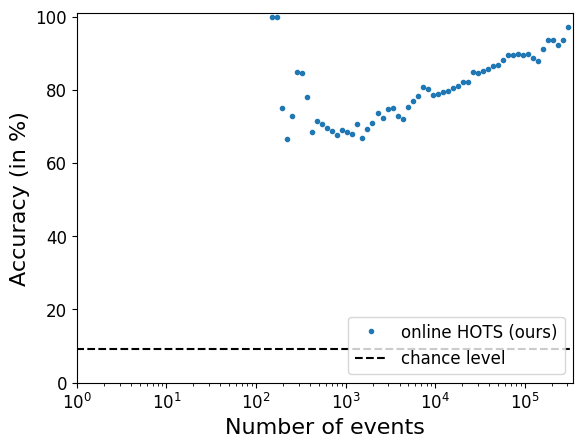

In [19]:
for mlr_threshold in [.4]:#, .5, .6, .7, .8, .9]:
    onlinac_thres, best_probability, meanac, lastac = online_accuracy(classif_layer, tau_cla, testoutputloader, results_path, sensor_size, testset_output.ordering, n_classes, ts_size = ts_size, mlr_threshold = mlr_threshold, ts_batch_size = int(ts_batch_size/2), save_likelihood = False, online_plot = True)

/tmp/ipykernel_1144460/3390144756.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['']*5);


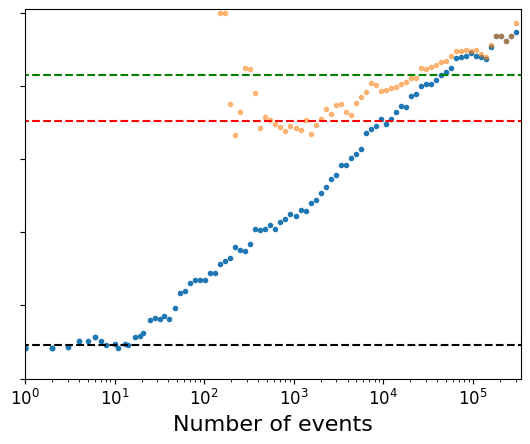

In [22]:
import matplotlib.pyplot as plt

event_90th = 344719
sampling = (np.logspace(0,np.log10(event_90th),100)).astype(int)

fig, ax = plt.subplots()
ax.semilogx(sampling[:-1],onlinac[sampling[:-1]]*100, '.', label='online HOTS (ours)');
ax.semilogx(sampling[:-1],onlinac_thres[sampling[:-1]]*100, '.', label='online HOTS \nwith threshold', alpha = .5);
ax.hlines(1/n_classes*100,0,event_90th, linestyles='dashed', color='k', label='chance level')
ax.hlines(score_nohomeo*100,0,event_90th, linestyles='dashed', color='r', label='original HOTS')
ax.hlines(score*100,0,event_90th, linestyles='dashed', color='g', label='HOTS with \nhomeostasis')
ax.set_xlabel('Number of events', fontsize=16);
ax.axis([1,event_90th,0,101]);
#plt.title('LR classification results evolution as a function of the number of events');
plt.setp(ax.get_xticklabels(),fontsize=12)
#ax.set_yticks([])
plt.setp(ax.get_yticklabels(),fontsize=12)
#ax.set_ylabel('Accuracy (in %)', fontsize=16);
#ax.legend(fontsize=12, loc='lower right');
    #printfig(fig, figure_name)
ax.set_yticklabels(['']*5);

In [26]:
name = 'gesture_online.pdf'

dpi_exp = None
bbox = 'tight'
path = '../../manuscript/fig/'
#path = '../../GrimaldiEtAl2020HOTS_clone_laurent/fig'
fig.savefig(path+name, dpi = dpi_exp, bbox_inches=bbox, transparent=True)

In [28]:
print(tauz)

[10000.0, 160000.0]
